# Staring Array Modelling

This notebook forms part of a series on [computational optical radiometry](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi).  The notebooks can be downloaded from [Github](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi). These notebooks are constantly revised and updated, please revisit from time to time.  


[<img src="https://zenodo.org/badge/doi/10.5281/zenodo.9910.png"   align="left"/>](http://dx.doi.org/10.5281/zenodo.9910)


The date of this document and module versions used in this document are given at the end of the file.  
Feedback is appreciated: neliswillers at gmail dot com.

## Overview

The pyradi [`rystare`](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html) module models the signal and noise in CCD and CMOS staring array sensors.  The code is originally based on the Matlab code described in *'High-level numerical simulations of noise in solid-state photosensors: review and tutorial'* by Mikhail Konnik and James Welsh, arXiv:1412.4031v1 [astro-ph.IM], available [here](http://arxiv.org/pdf/1412.4031.pdf)

Good references for this work include James R Janesick's books ['Photon Transfer'](http://spie.org/Publications/Book/725073) and ['Scientific Charge-Coupled Devices'](http://spie.org/Publications/Book/374903)



## Concept

<font color="red">This is an early draft of the notebook, visit later for a more detailed update.</font>

The current version of the notebook demonstrates Konnik's 'Advanced' model.  For more information and detailed documentation see the [`rystare` documentation](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html) or 
[the original Matlab code](https://bitbucket.org/aorta/highlevelsensorsim)

This model experiments with using HDF5 as a structured data store.  The motivation for this use and more information is available [here](https://github.com/NelisW/pyradi/blob/master/pyradi/hdf5-as-data-format.md)

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import re
import os.path
from scipy.optimize import curve_fit
import datetime

from matplotlib import cm as mcm
import matplotlib.mlab as mlab
import scipy.constants as const
import collections

%matplotlib inline

# %reload_ext autoreload
# %autoreload 2

# import xlsxwriter

import pyradi.ryplot as ryplot
import pyradi.ryfiles as ryfiles
import pyradi.rystare as rystare
import pyradi.ryutils as ryutils
import pyradi.rypflux as rypflux

from IPython.display import HTML
from IPython.display import Image
from IPython.display import display
from IPython.display import FileLink, FileLinks

#make pngs at 150 dpi
import matplotlib as mpl
mpl.rc("savefig", dpi=300)
mpl.rc('figure', figsize=(10,8))
# %config InlineBackend.figure_format = 'svg'

pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 150)

# Imager radiometry

## Irradiance in the focal plane and electron count in the detector

![images/sensor-diagram.png](images/sensor-diagram.png)

Consider a source at range $R_{01}$ illuminated with illumination/irradiance $E_0$ at a single wavelength.  The pixel flux is given by

\begin{equation}
\Phi_s = \frac{ L_0 A_0 A_1 \tau_a}{R_{01}^2}
\end{equation}

where the radiance $L_0$ is given by 

\begin{equation}
L_0 = \frac{E_0 \rho}{\pi}
\end{equation}

where $E_0$ is the illumination on the object, where the reflectance is assumed to be 
 lambertian,  and where $\rho$ is the diffuse source reflectance.  Then 
 
\begin{equation}
\Phi_s = \frac{ E_0 \rho A_0 A_1\tau_a}{\pi R_{01}^2}
\end{equation}

The pixel field of view is given by $A_0/R^2_{01} = A_s/f_s^2 = \Omega_p$. The sensor clear aperture area can be written in terms of f-number as $A_1 = f_s^2 \pi/(4 F_\#^2)$. Replacing in the above equation yields

\begin{equation}
\Phi_s 
= \frac{ E_0 \rho}{\pi} \frac{f_s^2 \pi }{4 F_\#^2} \Omega_p \tau_a
=  \frac{  E_0 \rho A_s \tau_a}{4 F_\#^2}  
=  \frac{\pi  L_0 \rho A_s \tau_a}{4 F_\#^2}  
\end{equation}

The irradiance in the focal plane is then 

\begin{equation}
E_s = \frac{\Phi_s }{ A_s} 
= \frac{  E_0 \rho \tau_a}{4 F_\#^2}  
= \frac{\pi  L_0 \rho \tau_a}{4 F_\#^2}  
\end{equation}

The flux passing through the detector area is $E_s\, A_d$.  If the flux is defined in terms of photons per second, the number of photons accumulated in the detector during integration time $t_{\textrm{int}}$ is  $E_s\, A_d\, t_{\textrm{int}}$.  The electron count accumulated during the integration time is then

\begin{equation}
n = E_s A_d\, t_{\textrm{int}}
= \left(\frac{\pi\, t_{\textrm{int}}\,P\, A_d}{4\, F_\#^2} \right) \left( \rho\, \tau_a\, L_0\right)
\end{equation}

where the factor $P$ is the fractional clear aperture (in case some obscuration is present).

The solid angle of the optics' f-number cone is $\Omega_{F_\#}=\pi/(4F_\#^2)$, hence the above equation can be written

\begin{equation}
n = E_s A_d\, t_{\textrm{int}}
= \left(t_{\textrm{int}}\,P\, A_d \Omega_{F_\#}\right) \left( \rho\, \tau_a\, L_0\right)
\end{equation}

The last two equations forms the basis for the various electron-count contributions defined below.

### Constant spectral properties

Most sensors have relatively wide spectral response and the monochromatic derivation above must be extended to calculate the sum of fluxes at all wavelengths.
The spectral integrals in the equations below have the general form

\begin{equation}
(\cdots)\,\int_0^\infty
\eta_{\lambda}\, \tau_{o\lambda}\, \tau_{a\lambda}\, \rho_{\textrm{d}\lambda} \,
 L_{q\lambda} \,d \lambda 
\end{equation}

If a spectral variable, e.g., any or all of $(\eta_{\lambda}\, \tau_{o\lambda}\,\tau_{a\lambda}\, \rho_{\textrm{d}\lambda})$, can be assumed constant over spectral band, they can be taken out of th integral.  If all are constant only $L_{q\lambda}$ remains in the spectral band integral
 
\begin{equation}
\eta \tau_{o} \tau_{a}  \rho_\textrm{d} 
\int_0^\infty L_{q\lambda} \;d\lambda
\end{equation}



### Photon radiance

By setting $ t_{\textrm{int}}=P=A_d=\cos\theta=\eta=\tau_{o}=\tau_{a}=\rho_\textrm{d}=\Omega_{F_\#}=1$ and $F_\#=\sqrt{\pi/4}$, the equation simplifies to the wideband photon rate radiance at the target 

\begin{equation}
L_{\textrm{q}}
=
\int_0^\infty L_{q\lambda} \;d\lambda
\end{equation}

## Electron count  for various sources

This section considers the electron count for a variety of sources.  These equations form the basis for the library implementation that is used in the rest of the document.

### Self emitted flux

The thermal scene-radiance photon count is given by

\begin{equation}
n_{\textrm{sceneT}}
=
\left(\frac{\pi\,t_{\textrm{int}}\, P\,  A_d }{4\,F_\#^2}\right)
\int_0^\infty 
(\eta_{\lambda}\, \tau_{o\lambda}\, \tau_{a\lambda})\,
(\epsilon_{\lambda}\, L_\lambda(T_\textrm{source}))\,
d\lambda
\end{equation}

where
$t_{\textrm{int}}$ is the integration time,
$P$ is the fraction of clear aperture, 
$A_d$ is the detector area, 
$F_\#$ is the f-number, 
$\eta_{\lambda}$ is the detector quantum efficiency,
$\tau_{o\lambda}$ is the optics transmittance, 
$\tau_{f\lambda}$ is the sensor filter transmittance, 
$\tau_{a\lambda}$ is the atmospheric transmittance, 
$\epsilon_{\lambda}$ is the source/background emissivity,and
$L_\lambda(T_\textrm{source})$ the Planck photon rate radiance at source/background temperature $T_\textrm{source}$.




### Reflected flux

The electron count in the detector can be calculated from the scene or source radiance using
 
\begin{equation}
n_{\textrm{sceneR}}
=
\left(\frac{\pi\, t_{\textrm{int}}\, P\,  A_d}{4\,F_\#^2}\right)
\cdot \cos\theta \cdot
\int_0^\infty
(\eta_{\lambda}\, \tau_{o\lambda}\, \tau_{a\lambda})\,( \psi\rho_{\textrm{d}\lambda} \,
 L_{q\lambda}(T_\textrm{illum}) )\,
d \lambda 
\end{equation}

where
$n_{\textrm{scene}}$  is the number of electrons,
$t_{\textrm{int}}$ is the sensor integration time, 
$P$ is the fraction of unobscured optical aperture, 
$A_d$ is the area of the detector, 
$\theta$ is the angle between the surface normal vector and the primary source (if not the sun or the moon, $\theta=0$),
$F_\#$ is the f-number (assuming infinite conjugates), 
$\eta_{\lambda}$ is the detector spectral quantum efficiency, 
$\tau_{o\lambda}$ is the spectral optics and filter transmittance, 
$\tau_{\lambda}$ is the spectral atmospheric transmittance,
$\psi$ is the ratio of radiance on the illuminating source surface to radiance on the target source surface,
$\rho_{\textrm{d}\lambda}$ is the surface's diffuse spectral  reflection, 
$L_{q\lambda}$ is the spectral photon rate radiance at the surface, and
$T_\textrm{illum}$ is the temperature of the illuminating source$.

If the surface is illuminated by the sun, the spectral radiance at the surface becomes
$L_{q\lambda} = \psi \epsilon_\textrm{sun}\tau_\textrm{sun}L_{q\textrm{b}}(6000 K)$,
where 
$\psi=2.17\times 10^{-5}$ relates the sun's area and distance to radiance on the ground,
$\epsilon_\textrm{sun}=1$ is the sun emissivity, 
$\tau_\textrm{sun}$  is the atmospheric transmittance from the target to the sun, and
$L_{q\textrm{b}}(6000 K)$ is the Planck-law thermal radiance for a 6000 K source (approximation of the sun's surface temperature).

### Low light radiance

The approximate low light level scene radiance levels were calculated above and stored in the `dfPhotRates` DataFrame.  These values are already integrated over the spectral bandwidth, so the scene-induced electron count in the detector becomes
 
\begin{equation}
n_{\textrm{sceneR}}
=
\left(\frac{\pi\, t_{\textrm{int}}\, P\,  A_d}{4\,F_\#^2}\right)
\cdot \cos\theta\cdot
( \eta\, \tau_{o}\, \tau_{a})\, (\rho_\textrm{d} \,
 L_{qLL})\,
\end{equation}

where
$n_{\textrm{scene}}$  is the number of electrons,
$t_{\textrm{int}}$ is the sensor integration time, 
$P$ is the fraction of unobscured optical aperture, 
$A_d$ is the area of the detector, 
$\theta$ is the angle between the surface normal vector and the primary source (if not the sun or the moon, $\theta=0$),
$F_\#$ is the f-number, 
$\eta$ is the detector quantum efficiency, 
$\tau_{o}$ is the optics transmittance, 
$\tau_{a}$ is the atmospheric transmittance,
$\rho_\textrm{d}$ is the surface reflection, and 
$L_{qLL}$ is the photon rate radiance of the surface, as calculated above in `dfPhotRates`.


### Hot optics radiance

For infrared sensors the thermal hot-optics photon count is given by 

\begin{equation}
n_{\textrm{optics}}
=
\left(\frac{\pi t_{\textrm{int}} P  A_d }{4F_\#^2}\right)\cdot
\int_0^\infty \eta_{\lambda}  
(1-\tau_{o\lambda}) L_\lambda(T_\textrm{optics})
d\lambda
\end{equation}

where
the optics emissivity is given by
$\epsilon_{\textrm{optics}\lambda}=(1-\tau_{o\lambda})$.
                                          

Assuming no stray light in the visual system, the visual optics photon count is given by 

\begin{equation}
n_{\textrm{optics}}=0
\end{equation}
                                          

### Path radiance

The path radiance  photon count is given by

\begin{equation}
n_{\textrm{path}}
=
\left(\frac{\pi t_{\textrm{int}} P  A_d }{4F_\#^2}\right)\cdot
\int_0^\infty \eta_{\lambda}  
\tau_{o\lambda} L_\lambda(T_\textrm{path})
d\lambda
\end{equation}

where $L_\lambda(T_\textrm{path}$ is the path radiance.
 
Path radiance at one range can be scaled to path radiance at another range.  It can be shown that path radiance can be approximated by

\begin{equation}
L_{\lambda\textrm{path}} = L_{\lambda\textrm{path}\infty}\left(1-\tau_{\textrm{path}}\right)
\end{equation}

where
$L_{\lambda\textrm{path}\infty}$ is the path radiance for an infinitely long path where $\tau_{\textrm{path}}=0$.
 

### Complete model

The total electron count in the detector is given by the sum of all the terms defined above.  The various contributions are structured in this diagram

![images/rypflux02.png](images/rydecount02.png)

where the underlined $\underline{T}$, $\underline{A}$, and $\underline{S}$ signifies the origin of the contribution (Target, Atmosphere, and Sensor).

### Target characteristics 

In order to benchmark the signal levels in the rest of the document, we calculate the irradiance/illumination on the detector for a target reflectance of 0.3,  an atmospheric transmittance of 0.5, optics transmittance of 0.9, and a few sensor f-numbers.

## Focal plane irradiance at low light levels

The photon rate radiance at low light levels is analysed in some detail in the [Optical Sources notebook](https://github.com/NelisW/ComputationalRadiometry/blob/master/07-Optical-Sources.ipynb).


In [3]:

pf = rypflux.PFlux()
lx = pf.lllux

def calcIrrad(lx, rho, taua, tauo, fno):
    return lx * rho * taua * tauo / (4 * fno ** 2)

df = pd.DataFrame(lx).transpose()
df.columns = pf.llluxCols

rho = 0.3
taua = 0.5
tauo = 0.9
fnos = [1.4, 2, 2.74, 3.8]
for fno in fnos:
# #     http://stackoverflow.com/questions/21188504/python-pandas-apply-a-function-with-arguments-to-a-series-update
    df['{}'.format(fno)] = df['Irradiance-lm/m2'].apply(calcIrrad, args=(rho, taua, tauo, fno) )
    
df.sort_values(by='Irradiance-lm/m2',inplace=True)
print(df.drop(['FracPhotop'],axis=1))

                Irradiance-lm/m2  ColourTemp          1.4             2          2.74           3.8
Overcast night            0.0001      5000.0     0.000002  8.437500e-07  4.495445e-07  2.337258e-07
Star light                0.0011      5000.0     0.000019  9.281250e-06  4.944989e-06  2.570983e-06
Quarter moon              0.0108      4150.0     0.000186  9.112500e-05  4.855080e-05  2.524238e-05
Full moon                 0.1080      4150.0     0.001860  9.112500e-04  4.855080e-04  2.524238e-04
Deep twilight             1.0800     10000.0     0.018597  9.112500e-03  4.855080e-03  2.524238e-03
Twilight                 10.8000     10000.0     0.185969  9.112500e-02  4.855080e-02  2.524238e-02
Very dark day           107.0000      7000.0     1.842474  9.028125e-01  4.810126e-01  2.500866e-01
Overcast day           1075.0000      6000.0    18.510842  9.070312e+00  4.832603e+00  2.512552e+00
Full sky light        10752.0000     12000.0   185.142857  9.072000e+01  4.833502e+01  2.513019e+01


In [4]:
lx = pf.lllux

def calcIrrad(lx, rho, taua, tauo, fno):
    return lx * rho * taua * tauo / (4 * fno ** 2)

df = pd.DataFrame(lx).transpose()
df.columns = pf.llluxCols

rho = 0.3
taua = 0.5
tauo = 0.9
fnos = [1.4, 2, 2.74, 3.8, 5.4, 7.5, 10, 14.8, 20]
for fno in fnos:
#     http://stackoverflow.com/questions/21188504/python-pandas-apply-a-function-with-arguments-to-a-series-update
    df['{}'.format(fno)] = df['Irradiance-lm/m2'].apply(calcIrrad, args=(rho, taua, tauo, fno) )
    
df.sort_values(by='Irradiance-lm/m2')

,Irradiance-lm/m2,ColourTemp,FracPhotop,1.4,2,2.74,3.8,5.4,7.5,10,14.8,20
Overcast night,0.0001,5000.0,0.0,0.000002,8.437500e-07,4.495445e-07,2.337258e-07,1.157407e-07,6.000000e-08,3.375000e-08,1.540814e-08,8.437500e-09
Star light,0.0011,5000.0,0.2,0.000019,9.281250e-06,4.944989e-06,2.570983e-06,1.273148e-06,6.600000e-07,3.712500e-07,1.694896e-07,9.281250e-08
Quarter moon,0.0108,4150.0,0.4,0.000186,9.112500e-05,4.855080e-05,2.524238e-05,1.250000e-05,6.480000e-06,3.645000e-06,1.664080e-06,9.112500e-07
Full moon,0.1080,4150.0,0.6,0.001860,9.112500e-04,4.855080e-04,2.524238e-04,1.250000e-04,6.480000e-05,3.645000e-05,1.664080e-05,9.112500e-06
Deep twilight,1.0800,10000.0,0.8,0.018597,9.112500e-03,4.855080e-03,2.524238e-03,1.250000e-03,6.480000e-04,3.645000e-04,1.664080e-04,9.112500e-05
Twilight,10.8000,10000.0,1.0,0.185969,9.112500e-02,4.855080e-02,2.524238e-02,1.250000e-02,6.480000e-03,3.645000e-03,1.664080e-03,9.112500e-04
Very dark day,107.0000,7000.0,1.0,1.842474,9.028125e-01,4.810126e-01,2.500866e-01,1.238426e-01,6.420000e-02,3.611250e-02,1.648671e-02,9.028125e-03
Overcast day,1075.0000,6000.0,1.0,18.510842,9.070312e+00,4.832603e+00,2.512552e+00,1.244213e+00,6.450000e-01,3.628125e-01,1.656376e-01,9.070312e-02
Full sky light,10752.0000,12000.0,1.0,185.142857,9.072000e+01,4.833502e+01,2.513019e+01,1.244444e+01,6.451200e+00,3.628800e+00,1.656684e+00,9.072000e-01
Sun light,107527.0000,5700.0,1.0,1851.549107,9.072591e+02,4.833817e+02,2.513183e+02,1.244525e+02,6.451620e+01,3.629036e+01,1.656792e+01,9.072591e+00


## Sensor model data

The following code sets up the sensor model data.  

Files remaining open, not closed after use, poses a problem in the notebook context where cells may be executed indivdually.  The limit the occurence of open files we open and close the file in each cell.

In [5]:
#set up the parameters for this run and open the HDF5 file
outfilename = 'Output'
prefix = 'PA'
pathtoimage = ryfiles.downloadFileUrl('https://github.com/NelisW/pyradi/raw/master/pyradi/data/image-Stairslin-40-100-520.hdf5',  
                              saveFilename='image-Stairslin-40-100-520.hdf5')

#open the file to create data structure and store the results, remove if exists
hdffilename = '{}{}.hdf5'.format(prefix, outfilename)
if os.path.isfile(hdffilename):
    os.remove(hdffilename)

In [6]:
strh5 = ryfiles.open_HDF(hdffilename)

#sensor parameters
strh5['rystare/sensortype'] = 'CCD' # CMOS/CCD must be in capitals
strh5['rystare/fillfactor'] = 1.0 # Pixel Fill Factor for full-frame CCD photo sensors.
strh5['rystare/integrationtime'] = 0.01 # Exposure/Integration time, [sec].
strh5['rystare/externalquantumeff'] = 0.8  # external quantum efficiency, fraction not reflected.
strh5['rystare/quantumyield'] = 1. # number of electrons absorbed per one photon into material bulk
strh5['rystare/fullwellelectrons'] = 2e4 # full well of the pixel (how many electrons can be stored in one pixel), [e]

# Light Noise parameters
strh5['rystare/flag/photonshotnoise'] = True #photon shot noise.

# photo response non-uniformity noise (PRNU), or also called light Fixed Pattern Noise (light FPN)
strh5['rystare/detector/response/NU/flag'] = True
strh5['rystare/detector/response/NU/seed'] = 362436069
strh5['rystare/detector/response/NU/model'] = 'Janesick-Gaussian' 
strh5['rystare/detector/response/NU/spread'] = 0.01 # sigma [about 1\% for CCD and up to 5% for CMOS];

# Dark Current Noise parameters
strh5['rystare/flag/darkcurrent'] = True
strh5['rystare/operatingtemperature'] = 300. # operating temperature, [K]
strh5['rystare/darkfiguremerit'] = 1. # dark current figure of merit, [nA/cm2].  For very poor sensors, add DFM
#  Increasing the DFM more than 10 results to (with the same exposure time of 10^-6):
#  Hence the DFM increases the standard deviation and does not affect the mean value.

# dark current shot noise
strh5['rystare/flag/DarkCurrent-DShot'] = True

#dark current Fixed Pattern uniformity 
strh5['rystare/darkresponse/NU/flag'] = True
strh5['rystare/darkresponse/NU/seed'] = 362436128
strh5['rystare/darkresponse/NU/limitnegative'] = True # only used with 'Janesick-Gaussian' 
strh5['rystare/darkresponse/NU/model'] = 'LogNormal' #suitable for long exposures
strh5['rystare/darkresponse/NU//spread'] = 0.4 #lognorm_sigma.

#sense node charge to voltage
strh5['rystare/sensenode/nonlinear/flag'] = False
strh5['rystare/sensenode/nonlinear/alpha'] = 0.05 #how many times should A_SF be increased due to non-linearity?    
# strh5['rystare/sensenode/gain'] = 5e-6 # Sense node gain, A_SN [V/e]
strh5['rystare/sensenode/gain'] = 50e-06 # Sense node gain, A_SN [V/e]
strh5['rystare/sensenode/resetnoise/flag'] = True
strh5['rystare/sensenode/resetnoise/factor'] = 0.8 #[0,1]the compensation factor of the Sense Node Reset Noise: 
strh5['rystare/sensenode/vrefreset'] = 3.1 # Reference voltage to reset the sense node. [V] typically 3-10 V.

#source follower
strh5['rystare/sourcefollower/gain'] = 1. # Source follower gain, [V/V], lower means amplify the noise.
strh5['rystare/sourcefollower/noise/flag'] = True
strh5['rystare/sourcefollower/flickerCornerHz'] = 1e6 #flicker noise corner frequency $f_c$ in [Hz], where power spectrum of white and flicker noise are equal [Hz].
strh5['rystare/sourcefollower/whitenoisedensity'] = 15e-9 #thermal white noise [\f$V/Hz^{1/2}\f$, typically \f$15 nV/Hz^{1/2}\f$ ]
strh5['rystare/sourcefollower/deltaindmodulation'] = 1e-8 #[A] source follower current modulation induced by RTS [CMOS ONLY]
strh5['rystare/sourcefollower/dataclockspeed'] = 20e6 #Hz data rate clocking speed.
strh5['rystare/sourcefollower/freqsamplingdelta'] = 10000. #Hz spectral sampling spacing
strh5['rystare/sourcefollower/nonlinearity/flag'] = True
strh5['rystare/sourcefollower/nonlinearity/ratio'] = 1.05 # > 1 for lower signal, < 1 for higher signal

#dark current Offset Fixed Pattern 
strh5['rystare/darkoffset/NU/flag'] = True
strh5['rystare/darkoffset/NU/model'] = 'Janesick-Gaussian'
strh5['rystare/darkoffset/NU/spread'] = 0.0005 # percentage of (V_REF - V_SN)

# Correlated Double Sampling (CDS)
strh5['rystare/CDS/gain'] = 1. # CDS gain, [V/V], lower means amplify the noise.
strh5['rystare/CDS/sampletosamplingtime'] = 1e-6 #CDS sample-to-sampling time [sec].

# Analogue-to-Digital Converter (ADC)
strh5['rystare/ADC/num-bits'] = 12. # noise is more apparent on high Bits
strh5['rystare/ADC/offset'] = 0. # Offset of the ADC, in DN
strh5['rystare/ADC/nonlinearity/flag'] = False 
strh5['rystare/ADC/nonlinearity/ratio'] = 1.1

#For testing and measurements only:
strh5['rystare/flag/darkframe'] = False # True if no signal, only dark

strh5.flush()
strh5.close()

Download the image file from the GitHub directory. Normally you will prepare this file for your specific application.  The format for this file is described [here](http://nelisw.github.io/pyradi-docs/_build/html/rystare.html#pyradi.rystare.create_HDF5_image).

In [7]:

if pathtoimage is not None:
    imghd5 = ryfiles.open_HDF(pathtoimage)
else:
    imghd5 = None        

The input data has been set up, now execute the model. To test the model performance at the limits, uncomment one of the two `scaleInput` lines.  The first line provides a signal with small SNR whereas the second line provides a signal that saturates the well.

In [8]:
# scaleInput = 0.01 # for low SNR for Disk image
# scaleInput = 5 # saturates the well to full capacity for Disk image
scaleInput = 1 

if imghd5 is not None:
    strh5 = ryfiles.open_HDF(hdffilename)
    
    #images must be in photon rate irradiance units q/(m2.s)
    
    strh5['rystare/irradianceLux'] = scaleInput * imghd5['image/irradianceLux'].value
    strh5['rystare/signal/photonRateIrradianceNoNoise'] = scaleInput * imghd5['image/PhotonRateIrradianceNoNoise'].value
    strh5['rystare/signal/photonRateIrradiance'] = scaleInput * imghd5['image/PhotonRateIrradiance'].value
    strh5['rystare/pixelPitch'] = imghd5['image/pixelPitch'].value
    strh5['rystare/imageName'] = imghd5['image/imageName'].value
    strh5['rystare/imageFilename'] = imghd5['image/imageFilename'].value
    strh5['rystare/imageSizePixels'] = imghd5['image/imageSizePixels'].value
    strh5['rystare/wavelength'] = imghd5['image/wavelength'].value
    strh5['rystare/imageSizeRows'] = imghd5['image/imageSizeRows'].value
    strh5['rystare/imageSizeCols'] = imghd5['image/imageSizeCols'].value
    strh5['rystare/imageSizeDiagonal'] = imghd5['image/imageSizeDiagonal'].value

    #calculate the noise and final images
    strh5 = rystare.photosensor(strh5) # here the Photon-to-electron conversion occurred.
    strh5.flush()
    strh5.close()


Print some statistics of the sensor, noise and image

In [9]:
print(rystare.get_summary_stats(hdffilename))

PAOutput.hdf5
Image file name             : image-Stairslin-40-100-520.hdf5
Image name                  : Stairslin-40-40
Sensor type                 : CCD 
Pixel pitch                 : [  5.00000000e-06   5.00000000e-06] m
Image size diagonal         : 0.00264764045897 m
Image size pixels           : [100 520] 
Fill factor                 : 1.0
Full well electrons         : 20000.0 e
Integration time            : 0.01 s
Wavelength                  : 5.5e-07 m
Operating temperature       : 300.0 K
Max image irradiance         : 25.2269954681 lux
PhotonRateIrradianceNoNoise : q/(m2.s) mean=3.39785e+16, var=1.20289e+33
SignalPhotonRateIrradiance  : q/(m2.s) mean=3.39785e+16, var=1.20289e+33
SignalPhotonsNU             : q/(m2.s) mean=3.39744e+16, var=1.20278e+33
signalLight                 : e mean=6.79489e+03, var=4.81113e+07
signalDarkNoNoise           : e mean=1.54764e+01, var=0.00000e+00
signalDark                  : e mean=4.08466e+01, var=1.31274e+03
SignalElectrons             : 

The source follower DCS noise is shown next.

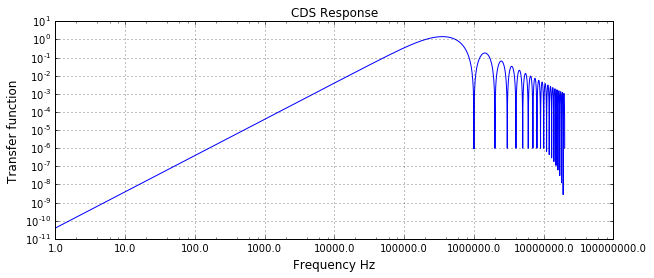

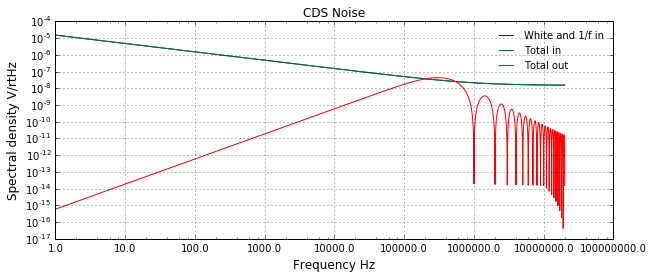

In [10]:
#open the sensor data file
%matplotlib inline
strh5 = ryfiles.open_HDF(hdffilename)
p = ryplot.Plotter(1,1,1,figsize=(10,4))
p.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         strh5['rystare/sourcefollower/noise/cdsgain'].value.T,'CDS Response',
        'Frequency Hz','Transfer function')
q = ryplot.Plotter(2,1,1,figsize=(10,4))
q.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         np.sqrt(strh5['rystare/sourcefollower/noise/spectrumwhiteflicker'].value.T),label=['White and 1/f in'])
if strh5['rystare/sensortype'].value in ['CMOS']:
    q.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         np.sqrt(strh5['rystare/sourcefollower/noise/spectrumRTN'].value.T), label=['Burst / RTN in'])
q.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         np.sqrt(strh5['rystare/sourcefollower/noise/spectrumtotal'].value.T),label=['Total in'])
q.logLog(1, strh5['rystare/sourcefollower/noise/spectralfreq'].value.T, 
         np.sqrt(strh5['rystare/sourcefollower/noise/spectrumtotal'].value.T) * strh5['rystare/sourcefollower/noise/cdsgain'].value.T,'CDS Noise',
        'Frequency Hz','Spectral density V/rtHz',label=['Total out'])
strh5.flush()
strh5.close()

In [11]:
def plotResults(imghd5, hdffilename, arrayname, bins=50, plotscale=1.0, logscale=False):
    if imghd5 is not None and hdffilename is not None:
        #open the sensor data file
        strh5 = ryfiles.open_HDF(hdffilename)
        #get the prescribed array
        arr = strh5['{}'.format(arrayname)].value 
        maxarr = np.max(arr)
        arr = strh5['{}'.format(arrayname)].value * plotscale
        arr = np.where(arr > maxarr, maxarr,arr) / plotscale
        if logscale:
            arr = np.log10(arr + 0.5)
            ptitle = "log('{}'+0.5)".format(arrayname.replace('rystare/',''))
        else:
            ptitle = "'{}'".format(arrayname.replace('rystare/',''))
        
        his, bin = np.histogram(arr,bins=bins)
        
        if np.min(arr) != np.max(arr):
            arrshift = arr - np.min(arr)
            arrshift = 255 * arrshift/np.max(arrshift)
            p = ryplot.Plotter(1,2,1,figsize=(8, 4))
#             p.showImage(1, arr, ptitle=ptitle, cmap=ryplot.cubehelixcmap(), cbarshow=True);
            p.showImage(1, arr, ptitle=ptitle, cmap=mcm.jet, cbarshow=True);
            p.showImage(2, arrshift, ptitle=ptitle, cmap=mcm.gray, cbarshow=False);
        if not logscale:
            r = ryplot.Plotter(2,1,1,figsize=(7, 2))
            r.plot(1, (bin[1:]+bin[:-1])/2, his, '{}, {} bins'.format(arrayname.replace('rystare/',''), bins), 'Magnitude','Counts / bin')

        strh5.flush()
        strh5.close()

The graph in the rest of the document shows signals at the stations marked in the signal flow diagram shown below.

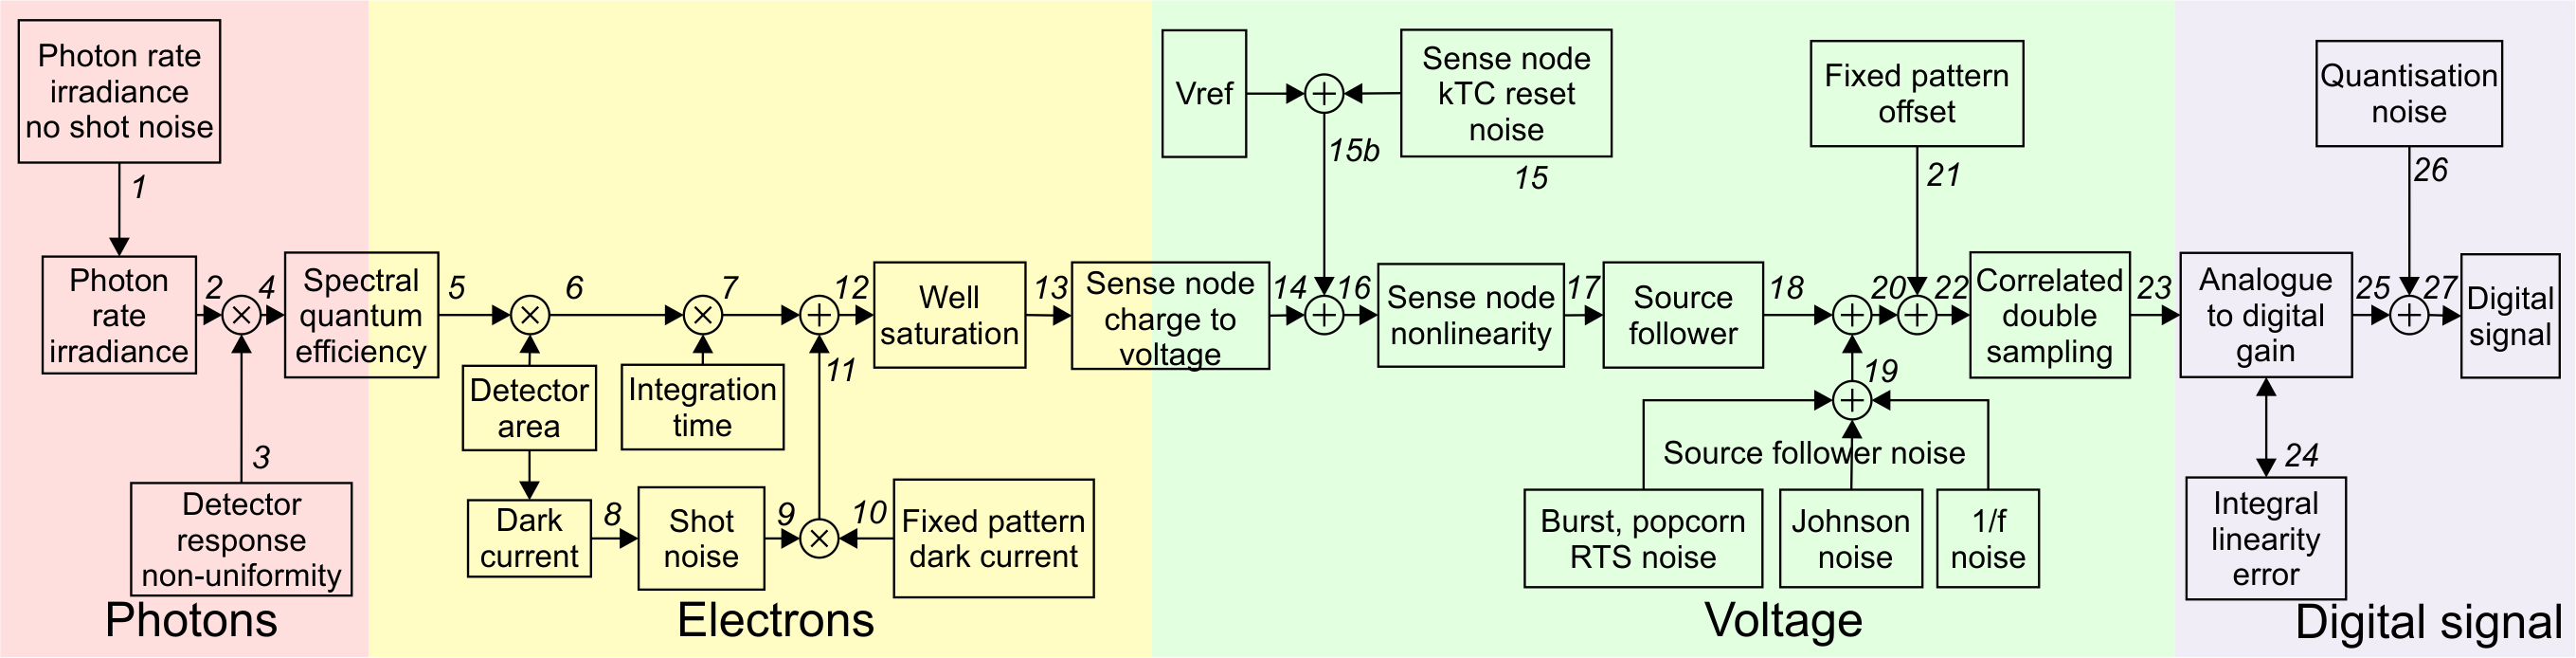

In [13]:
display(Image(filename='images/camerascheme-horiz-labelled.png', width=1000))

The externally created signal in photon rate irradiance [q/(m2.s)] (location 1 in the diagram).   This plot shows the image without photon noise.

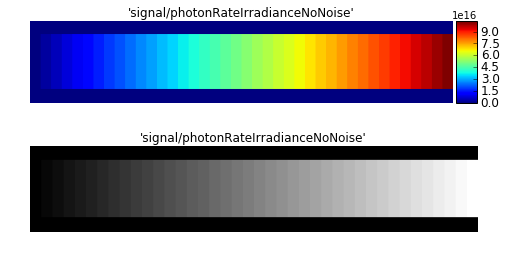

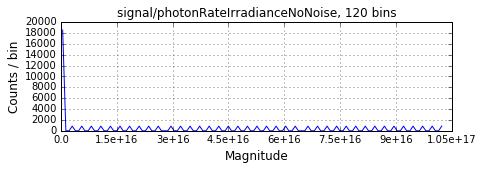

In [14]:
plotResults(imghd5, hdffilename, 'rystare/signal/photonRateIrradianceNoNoise', bins=120) 

The externally created signal in photon rate irradiance [q/(m2.s)] (location 2 in the diagram).   This plot shows the image with photon noise.

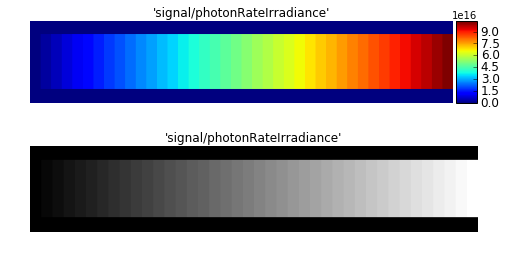

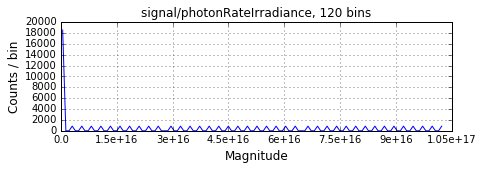

In [15]:
plotResults(imghd5, hdffilename, 'rystare/signal/photonRateIrradiance', bins=120) 

The photon rate multiplied with the integration time yields the maximum number of photons available for accumulation (location 4 in the diagram):

Detector element quantum efficiency (location 5 in the diagram):

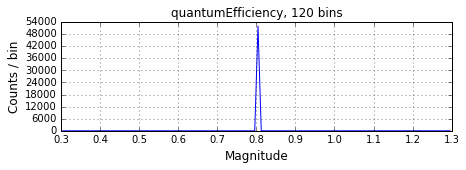

In [16]:
plotResults(imghd5, hdffilename, 'rystare/quantumEfficiency', bins=120) 

The focal plane's spatial nonuniformity is calculated next, as a Gaussian distribution around unity (location 6 in the diagram):

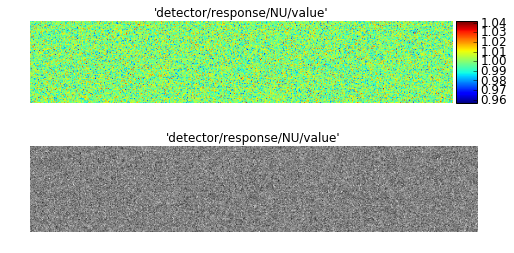

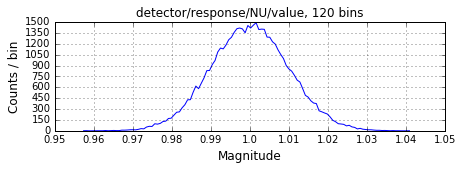

In [17]:
plotResults(imghd5, hdffilename, 'rystare/detector/response/NU/value', bins=120) 

The photon count multiplied with the nonuniformity yields the photon count actually recorded in the charge wells (location 7 in the diagram):

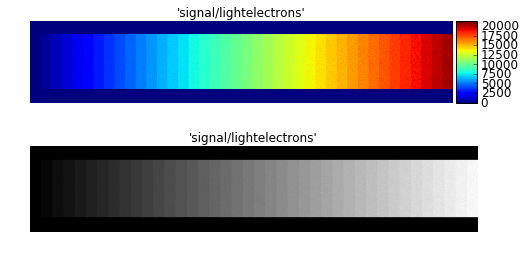

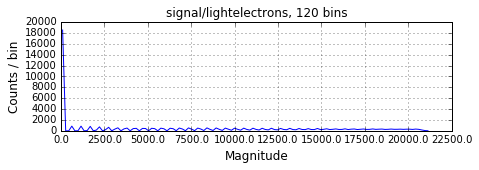

In [18]:
plotResults(imghd5, hdffilename, 'rystare/signal/lightelectrons', bins=120) 

The focal plane nonuniformity for dark noise generation for the advanced model follows a lognormal distribution.  The relatively few high values are quite evident in these graphs (location 10 in the diagram):


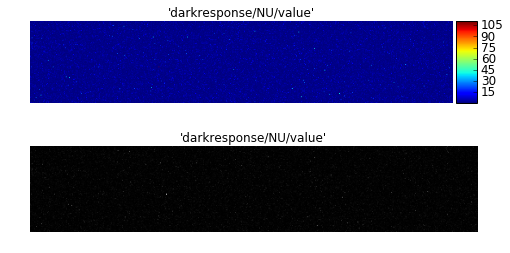

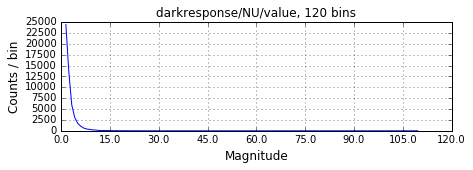

In [19]:
plotResults(imghd5, hdffilename, 'rystare/darkresponse/NU/value', bins=120) 


The dark noise signal is given by the dark noise nonuniformity multiplied by the mean dark current (location 9 in the diagram):


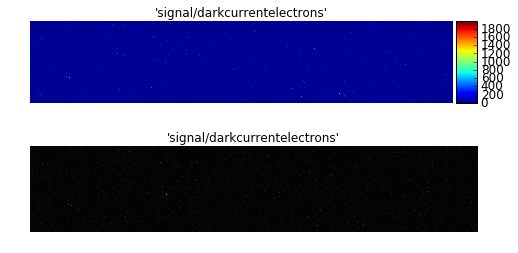

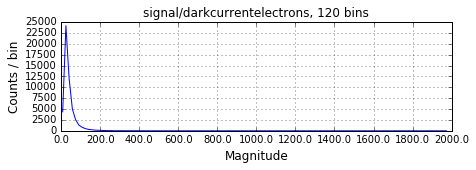

In [20]:
plotResults(imghd5, hdffilename, 'rystare/signal/darkcurrentelectrons', bins=120) 

The signal in electrons (location 12 in the diagram):

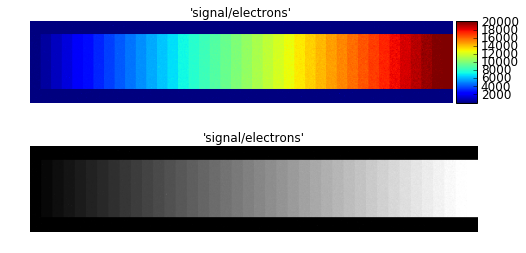

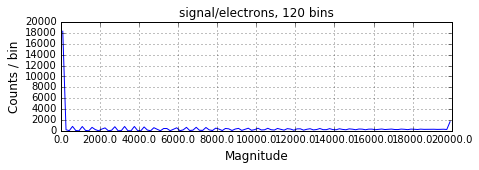

In [21]:
plotResults(imghd5, hdffilename, 'rystare/signal/electrons', bins=120) 

The reset noise variation over the array (location 15 in the diagram):

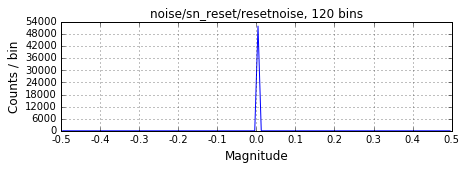

In [22]:
plotResults(imghd5, hdffilename, 'rystare/noise/sn_reset/resetnoise', bins=120) 

The source follower noise in electrons (location 19 in the diagram):

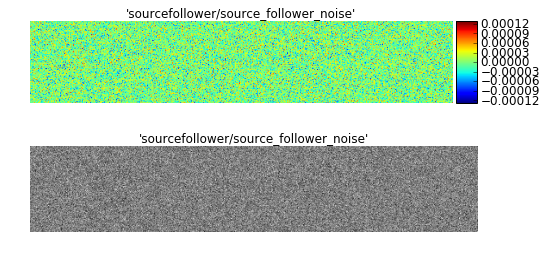

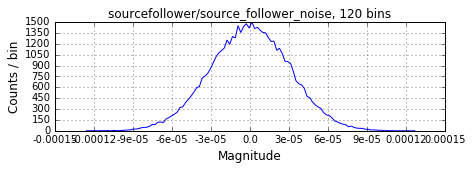

In [23]:
plotResults(imghd5, hdffilename, 'rystare/sourcefollower/source_follower_noise', bins=120) 

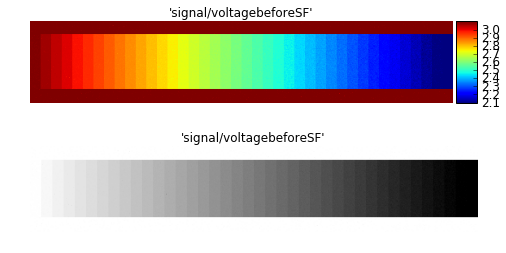

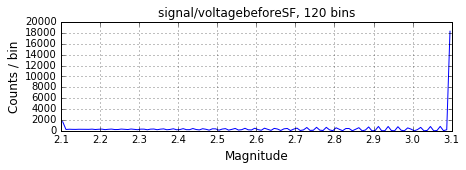

In [24]:
plotResults(imghd5, hdffilename, 'rystare/signal/voltagebeforeSF', bins=120) 

The (inverted) signal converted to voltage on the FPA output (location 18 in the diagram):

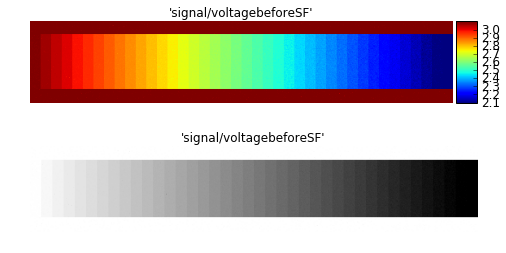

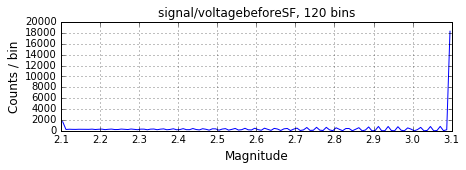

In [25]:
plotResults(imghd5, hdffilename, 'rystare/signal/voltagebeforeSF', bins=120)

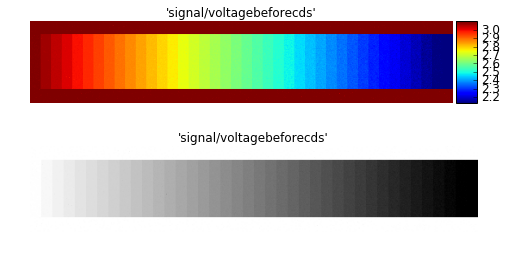

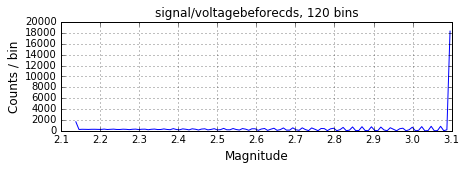

In [26]:
plotResults(imghd5, hdffilename, 'rystare/signal/voltagebeforecds', bins=120)

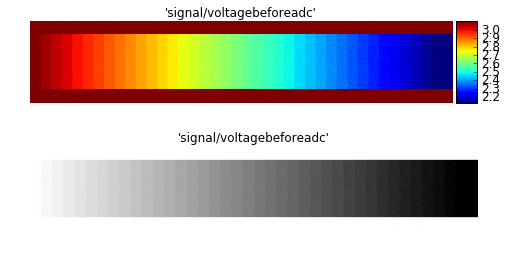

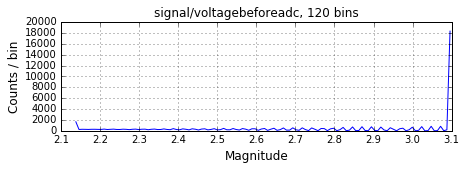

In [27]:
plotResults(imghd5, hdffilename, 'rystare/signal/voltagebeforeadc', bins=120)

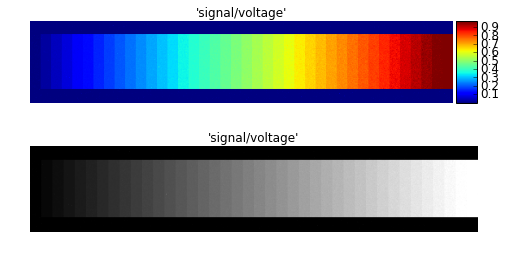

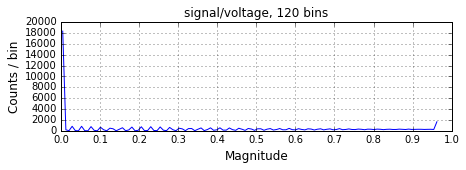

In [28]:
plotResults(imghd5, hdffilename, 'rystare/signal/voltage', bins=120) 

The dark offset nonuniformity (location 21 in the diagram):

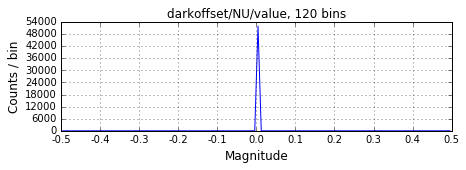

In [29]:
plotResults(imghd5, hdffilename, 'rystare/darkoffset/NU/value', bins=120) 

The ADC electronics linearity (location 

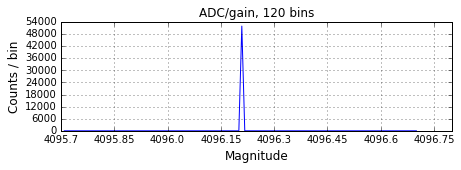

In [30]:
plotResults(imghd5, hdffilename, 'rystare/ADC/gain', bins=120) 

Signal converted to digital counts (location 25 in the diagram). This is the full scale dynamic range present in the image.  If the charge well is saturated, the value shown here should correspond with the full well capacity.

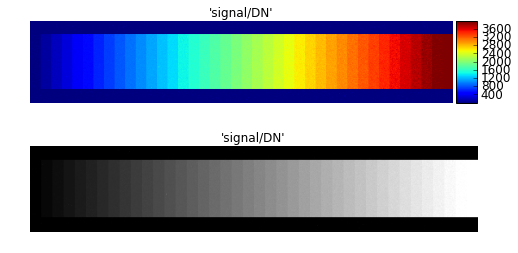

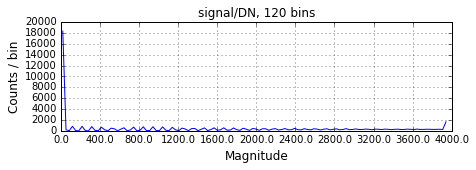

In [31]:
plotResults(imghd5, hdffilename, 'rystare/signal/DN', bins=120) 

Signal converted to digital counts  (location 25 in the diagram). This graph is intensity scaled 100 times larger than the previous image.  At this gain, the noise should be visible but higher signal levels will exceed the plot scale.

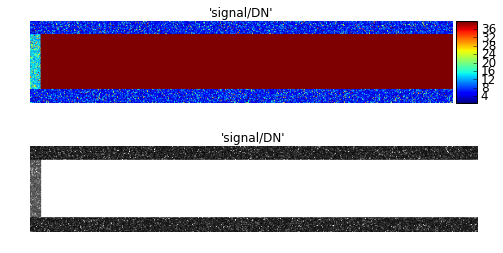

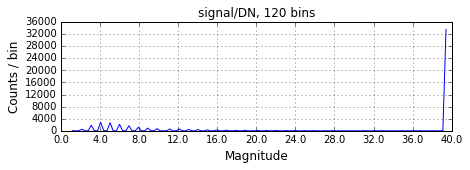

In [32]:
plotResults(imghd5, hdffilename, 'rystare/signal/DN', bins=120, plotscale=100) 

Signal converted to digital counts  (location 25 in the diagram). This graph shows the log-base10 values in the image. The image is offset by half a digital count to prevent log(0) errors.

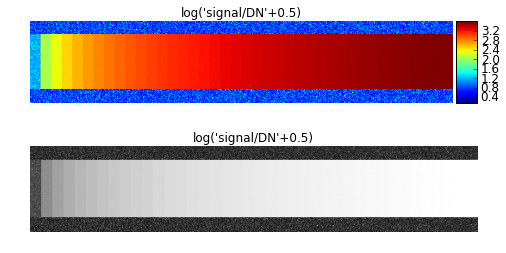

In [33]:
plotResults(imghd5, hdffilename, 'rystare/signal/DN', bins=120, plotscale=1, logscale=True) 

Next we will attempt to calculate the photon transfer function and signal to noise ratio for the various parts of the image.

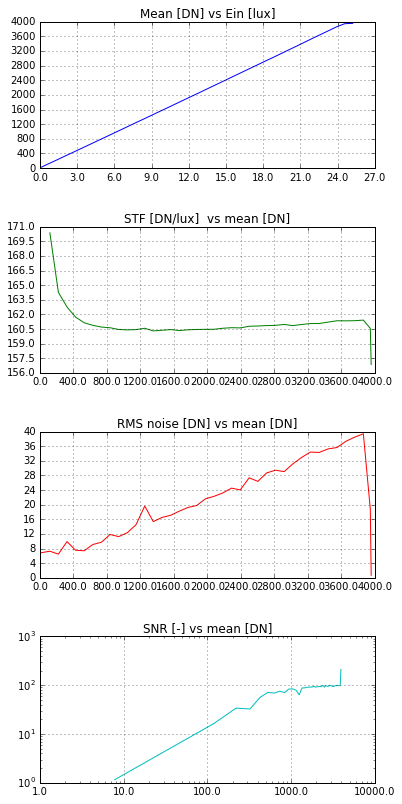

In [34]:
tplZones = collections.namedtuple('tplZones', ['ein', 'count','mean','var','std','snr','stf'], verbose=False)
lstZones = []
if imghd5 is not None:
    strh5 = ryfiles.open_HDF(hdffilename)
    #get the list of unique zones in the image
    arrnn = strh5['rystare/irradianceLux'].value
#     arrnn = strh5['rystare/PhotonRateIrradianceNoNoise'].value
    arr = strh5['rystare/signal/DN'].value
    uniqueZs, uCnts = np.unique(arrnn, return_counts=True)
#     print(uniqueZs, uCnts)
    for uniqueZ,ucnt in zip(uniqueZs,uCnts):
        zone = arr[arrnn==uniqueZ]
        mean = np.mean(zone)
        lstZones.append(tplZones(ein=uniqueZ, count=ucnt, mean=mean, 
                        var=np.var(zone-mean), std=np.std(zone-mean), 
                        snr=np.mean(zone)/np.std(zone-mean),
                        stf=np.mean(zone)/uniqueZ))
    strh5.flush()
    strh5.close()


# print(lstZones) 
#build numpy arrays of the results
ein = np.asarray([x.ein for x in lstZones])
mean = np.asarray([x.mean for x in lstZones])
var = np.asarray([x.var for x in lstZones])
std = np.asarray([x.std for x in lstZones])
snr = np.asarray([x.snr for x in lstZones])
stf = np.asarray([x.stf for x in lstZones])

p = ryplot.Plotter(1,4,1,figsize=(6,14));
p.plot(1,ein,mean,'Mean [DN] vs Ein [lux]');
p.plot(2,mean[2:],stf[2:],'STF [DN/lux]  vs mean [DN]');
p.plot(3,mean,std,'RMS noise [DN] vs mean [DN]');
p.logLog(4,mean[:-1],snr[:-1],'SNR [-] vs mean [DN]');

## Comments

1.  The small target image used here is relatively small and does not provide adequate statistics.  It serves as proof-of-concept in this analysis.

1. A more detailed discussion of the results will be done in due course.



## Python and [module versions, and dates](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [35]:
%load_ext version_information
%version_information numpy, scipy, matplotlib, pyradi

Software versions
Python 2.7.11 64bit [MSC v.1500 64 bit (AMD64)]
IPython 4.1.2
OS Windows 7 6.1.7601 SP1
numpy 1.10.4
scipy 0.17.0
matplotlib 1.5.1
pyradi 0.2.2
Wed Jun 22 13:23:16 2016 South Africa Standard Time

http://acrux.astro.ufsc.br/~kanaan/astrobs/ccd/lesser/Astr518-29sep03.pdf

